In [1]:
scenario = 'orig_nograd'

In [2]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import timedelta, datetime

# Função para ler o arquivo de coordenadas das estações RBMC
def read_rbmc_coordinates(file_path):
    columns = ['YearDay', 'Date', 'StationID', 'CoordSystem', 'StationName', 'StationCode',
               'X', 'Y', 'Z', 'StdX', 'StdY', 'StdZ']

    df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)
    df['Date'] = pd.to_datetime(df['Date'])
    df['X'] = df['X'].astype(float)
    df['Y'] = df['Y'].astype(float)
    df['Z'] = df['Z'].astype(float)
    df['StdX'] = df['StdX'].astype(float)
    df['StdY'] = df['StdY'].astype(float)
    df['StdZ'] = df['StdZ'].astype(float)

    return df

# Função para extrair os dados de processamento GNSS
def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data_lines = [line.strip() for line in lines if line[0].isdigit()]

    timestamps = []
    x_coords = []
    y_coords = []
    z_coords = []

    for line in data_lines:
        parts = line.split()
        timestamp = parts[0] + ' ' + parts[1]
        x = float(parts[2])
        y = float(parts[3])
        z = float(parts[4])

        timestamps.append(timestamp)
        x_coords.append(x)
        y_coords.append(y)
        z_coords.append(z)

    data = pd.DataFrame({
        'Timestamp': pd.to_datetime(timestamps),
        'X': x_coords,
        'Y': y_coords,
        'Z': z_coords
    })

    return data

# Função para calcular o RMSE
def calculate_rmse(predictions, true_values):
    return np.sqrt(np.mean((predictions - true_values) ** 2))

def doy_year_to_date(doy, year):
  """Converts day of year (DOY) and year to a date object.

  Args:
    doy: The day of year (1-366).
    year: The year (e.g., 2023).

  Returns:
    A datetime object representing the date.
  """
  date = datetime(year, 1, 1) + timedelta(days=doy - 1)
  return date

def get_closest_backward_date(query_date, datearray):
  """Finds the closest date in datearray that is less than or equal to query_date.

  Args:
    query_date: A pandas Timestamp object representing the query date.
    datearray: A pandas DatetimeIndex or Series representing the array of dates.

  Returns:
    A pandas Timestamp object representing the closest backward date, or None if
    no such date is found.
  """
  # Filter dates less than or equal to query_date
  valid_dates = datearray[datearray <= query_date]

  # If no valid dates are found, return None
  if valid_dates.empty:
    return None

  # Return the last (closest) valid date
  return valid_dates[-1]

def get_closest_date(query_date, datearray):
  """Finds the closest date in datearray to query_date.

  Args:
    query_date: A pandas Timestamp object representing the query date.
    datearray: A pandas DatetimeIndex or Series representing the array of dates.

  Returns:
    A pandas Timestamp object representing the closest date.
  """
  # Calculate absolute time differences
  time_diffs = abs(datearray - query_date)

  # Find the index of the minimum time difference
  closest_index = time_diffs.argmin()

  # Return the date at the closest index
  return datearray[closest_index]

In [3]:
all_scenarios = ['orig','orig_nograd']

charts_path = 'charts'

# Caminho base dos arquivos
base_input_path = r'C:\Users\kaue\ufpr.br\Lais Thuany Cardoso Theodoro - VMF3\saidas'
# base_path = f'/content/drive/My Drive/VMF3/dados/{scenario}/'
base_path = os.path.join(base_input_path,scenario)

# Meses e estações RBMC
meses = ['VERAO', 'INVERNO']
estacoes_rbmc = ['BRAZ', 'CUIB', 'UFPR', 'NAUS', 'POAL', 'PERC', 'ONRJ', 'SSA1', 'SAGA', 'POLI']

# cenario de processamento
scenario = 'orig'


# Caminho dos arquivos de coordenadas das estações
file_path_rbmc = 'Coordenadas_estacoes.txt'

# Lê os dados das coordenadas das estações RBMC
df_rbmc = read_rbmc_coordinates(file_path_rbmc)

# declarando o ano:
ano = 2020

# Define a data inicial e final para análise
# data_inicial = {'VERAO' : pd.Timestamp('2020-01-01'), "INVERNO" : pd.Timestamp('2020-06-01')}
# data_final = {'VERAO' : pd.Timestamp('2020-01-31'), "INVERNO" : pd.Timestamp('2020-07-31')}

C:\Users\kaue\AppData\Local\Temp\ipykernel_17656\2279821802.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)


In [4]:
# CÉLULA PRA TESTAR A INTEGRIDADE DOS DADOS

for mes in meses:
    for estacao in estacoes_rbmc:
      file_path_gnss = os.path.join(base_path, mes, estacao, 'pos')

      filelist = os.listdir(file_path_gnss)
      total_files_pos_files = [f for f in filelist if not '.stat' in f]
      total_stat_files = [f for f in filelist if '.stat' in f]

      print(mes,estacao,len(total_files_pos_files),len(total_stat_files),len(filelist))

VERAO BRAZ 31 0 31
VERAO CUIB 31 0 31
VERAO UFPR 31 0 31
VERAO NAUS 31 0 31
VERAO POAL 31 0 31
VERAO PERC 31 0 31
VERAO ONRJ 31 0 31
VERAO SSA1 31 0 31
VERAO SAGA 31 0 31
VERAO POLI 31 0 31
INVERNO BRAZ 31 0 31
INVERNO CUIB 31 0 31
INVERNO UFPR 31 0 31
INVERNO NAUS 31 0 31
INVERNO POAL 31 0 31
INVERNO PERC 31 0 31
INVERNO ONRJ 31 0 31
INVERNO SSA1 31 0 31
INVERNO SAGA 31 0 31
INVERNO POLI 31 0 31


In [5]:
unique_week_ref_dates = df_rbmc['Date'].unique()

unique_week_ref_dates

<DatetimeArray>
['2020-01-01 00:00:00', '2020-01-08 00:00:00', '2020-01-15 00:00:00',
 '2020-01-22 00:00:00', '2020-01-29 00:00:00', '2020-07-01 00:00:00',
 '2020-07-08 00:00:00', '2020-07-15 00:00:00', '2020-07-22 00:00:00',
 '2020-07-29 00:00:00']
Length: 10, dtype: datetime64[ns]

In [6]:
for sc in all_scenarios:
    os.makedirs(os.path.join(charts_path, sc), exist_ok=True)
    os.makedirs(os.path.join('saidas', sc), exist_ok=True)
    
sc_outpath = os.path.join('saidas',scenario)
sc_charts_outpath = os.path.join(charts_path,scenario)

In [7]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import timedelta, datetime

# Inicializa a lista para armazenar os resultados
results = []

# Itera sobre cada mês e estação RBMC
for mes in meses:
    for estacao in estacoes_rbmc:
        # Caminho dos arquivos de processamento GNSS
        file_path_gnss = os.path.join(base_path, mes, estacao, 'pos')

        # Encontre todos os arquivos .pos
        gnss_files = glob.glob(os.path.join(file_path_gnss, '*.pos'))

        for filepath in gnss_files:
            try:
                # Extrair o "day of year"
                doy = int(filepath.split('_')[-2][-4:-1])

                # Transformar DOY + ano em data
                doy_as_date = doy_year_to_date(doy, ano)

                # Data de referência semanal mais próxima
                ref_date = get_closest_date(doy_as_date, unique_week_ref_dates)

                # Coordenadas da estação
                station_coordinates = df_rbmc[
                    (df_rbmc['StationName'] == estacao) & (df_rbmc['Date'] == ref_date)
                ][['X', 'Y', 'Z']].values

                if station_coordinates.size == 0:
                    print(f"Sem coordenadas para {estacao} em {ref_date}. Pulando...")
                    continue

                # Processando o arquivo de resultados
                gnss_data = extract_data(filepath)

                # Calcula o RMSE para cada coordenada (X, Y, Z)
                rmse_x = calculate_rmse(gnss_data['X'].values, station_coordinates[0, 0])
                rmse_y = calculate_rmse(gnss_data['Y'].values, station_coordinates[0, 1])
                rmse_z = calculate_rmse(gnss_data['Z'].values, station_coordinates[0, 2])

                # Adiciona os resultados à lista
                results.append({
                    'Estacao': estacao,
                    'Periodo': mes,
                    'DOY': doy,
                    'DataReferencia': ref_date,
                    'RMSE_E': rmse_x,
                    'RMSE_Y': rmse_y,
                    'RMSE_Z': rmse_z
                })

            except Exception as e:
                print(f"Erro ao processar arquivo {filepath}: {e}")

# Cria um DataFrame com os resultados
df_results = pd.DataFrame(results)

# Exibe o resumo agrupado por estação e período
summary = df_results.groupby(['Estacao', 'Periodo']).mean(numeric_only=True)
print(summary)

# Salva os resultados em um arquivo CSV
# output_file = f'saidas/{scenario}/rmse_summary.csv'
output_file = os.path.join(sc_outpath,'rmse_summary.csv')
df_results.to_csv(output_file, index=False)
print(f"Resumo salvo em {output_file}")


actual_summary_path = os.path.join(sc_outpath,'rmse_general_summary.csv')
summary.to_csv(actual_summary_path, index=False)


                   DOY    RMSE_E    RMSE_Y    RMSE_Z
Estacao Periodo                                     
BRAZ    INVERNO  198.0  0.102828  0.181609  0.058721
        VERAO     16.0  0.099484  0.132821  0.043986
CUIB    INVERNO  198.0  0.089121  0.183464  0.069709
        VERAO     16.0  0.072788  0.123839  0.042457
NAUS    INVERNO  198.0  0.091458  0.176901  0.037007
        VERAO     16.0  0.081238  0.150922  0.027149
ONRJ    INVERNO  198.0  0.091851  0.132262  0.072783
        VERAO     16.0  0.089527  0.101738  0.055617
PERC    INVERNO  198.0  0.120677  0.124554  0.045087
        VERAO     16.0  0.122188  0.104668  0.031372
POAL    INVERNO  198.0  0.083871  0.179210  0.093404
        VERAO     16.0  0.079984  0.111716  0.069118
POLI    INVERNO  198.0  0.105666  0.178811  0.080811
        VERAO     16.0  0.104134  0.123536  0.062517
SAGA    INVERNO  198.0  0.093663  0.261531  0.054932
        VERAO     16.0  0.072470  0.173159  0.036542
SSA1    INVERNO  198.0  0.106965  0.119239  0.

In [8]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import timedelta, datetime

# Função para ler o arquivo de coordenadas geodésicas das estações RBMC
def read_rbmc_geodetic_coordinates(file_path):
    columns = ['YearDay', 'Date', 'StationID', 'CoordSystem', 'StationName', 'StationCode',
               'Latitude', 'Longitude', 'Height', 'StdLat', 'StdLon', 'StdHeight']

    df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Latitude'] = df['Latitude'].astype(float)
    df['Longitude'] = df['Longitude'].astype(float)
    df['Height'] = df['Height'].astype(float)
    df['StdLat'] = df['StdLat'].astype(float)
    df['StdLon'] = df['StdLon'].astype(float)
    df['StdHeight'] = df['StdHeight'].astype(float)

    return df

# Função para calcular o RMSE
def calculate_rmse(predictions, true_values):
    return np.sqrt(np.mean((predictions - true_values) ** 2))

# Função para conversão de coordenadas cartesianas para geodésicas
def convert_cartesian_to_geodetic(x, y, z):
    # Define os parâmetros do elipsoide WGS84
    a = 6378137.0  # Raio equatorial em metros
    f = 1 / 298.257223563  # Flattening
    e2 = 2 * f - f**2  # Excentricidade quadrada

    # Calcula latitude, longitude e altura
    lon = np.arctan2(y, x)
    p = np.sqrt(x**2 + y**2)
    lat = np.arctan2(z, p * (1 - f))
    h = 0

    # Método iterativo para determinar a latitude
    for _ in range(5):
        sin_lat = np.sin(lat)
        N = a / np.sqrt(1 - e2 * sin_lat**2)
        h = p / np.cos(lat) - N
        lat = np.arctan2(z + e2 * N * sin_lat, p)

    lat_deg = np.degrees(lat)
    lon_deg = np.degrees(lon)
    return lat_deg, lon_deg, h

# Função para calcular RMSE no sistema geodésico local (SGL)
def calculate_rmse_sgl(gnss_data, station_geodetic, station_std, station_cartesian):
    # Diferenças entre as coordenadas
    DX = gnss_data['X'].values - station_cartesian[0, 0]
    DY = gnss_data['Y'].values - station_cartesian[0, 1]
    DZ = gnss_data['Z'].values - station_cartesian[0, 2]

    # Conversão para Sistema Geodésico Local
    lat_rbmc = np.radians(station_geodetic[0, 0])
    lon_rbmc = np.radians(station_geodetic[0, 1])

    SGL_matrix = np.array([[-np.sin(lon_rbmc), np.cos(lon_rbmc), 0],
                           [-np.sin(lat_rbmc)*np.cos(lon_rbmc), -np.sin(lat_rbmc)*np.sin(lon_rbmc), np.cos(lat_rbmc)],
                           [np.cos(lat_rbmc)*np.cos(lon_rbmc), np.cos(lat_rbmc)*np.sin(lon_rbmc), np.sin(lat_rbmc)]])
    SGL = np.dot(SGL_matrix, np.array([DX, DY, DZ]))

    # Extraindo componentes Leste, Norte e Altura
    de = SGL[0]
    dn = SGL[1]
    du = SGL[2]

    # Desvios padrão
    std_e = station_std[0, 0]
    std_n = station_std[0, 1]
    std_u = station_std[0, 2]

    # Calcula o RMSE ponderado pelos desvios padrão
    rmse_e = calculate_rmse(de, (std_e + std_e.mean()) / 2)
    rmse_n = calculate_rmse(dn, (std_n + std_n.mean()) / 2)
    rmse_u = calculate_rmse(du, (std_u + std_u.mean()) / 2)
    rmse_planimetrico = np.sqrt(rmse_e**2 + rmse_n**2)

    return rmse_e, rmse_n, rmse_u, rmse_planimetrico

# Função principal para processar os dados GNSS
def process_gnss_data(meses, estacoes_rbmc, ano, base_path, df_rbmc, df_rbmc_geo):
    # Inicializa a lista para armazenar os resultados
    results = []

    # Itera sobre cada mês e estação RBMC
    for mes in meses:
        for estacao in estacoes_rbmc:
            # Caminho dos arquivos de processamento GNSS
            file_path_gnss = os.path.join(base_path, mes, estacao, 'pos')

            # Encontre todos os arquivos .pos
            gnss_files = glob.glob(os.path.join(file_path_gnss, '*.pos'))

            for filepath in gnss_files:
                try:
                    # Extrair o "day of year"
                    doy = int(filepath.split('_')[-2][-4:-1])

                    # Transformar DOY + ano em data
                    doy_as_date = doy_year_to_date(doy, ano)

                    # Data de referência semanal mais próxima
                    ref_date = get_closest_date(doy_as_date, df_rbmc['Date'].unique())

                    # Coordenadas geodésicas da estação
                    station_geodetic = df_rbmc_geo[
                        (df_rbmc_geo['StationName'] == estacao) & (df_rbmc_geo['Date'] == ref_date)
                    ][['Latitude', 'Longitude', 'Height']].values

                    # Coordenadas cartesianas da estação
                    station_cartesian = df_rbmc[
                        (df_rbmc['StationName'] == estacao) & (df_rbmc['Date'] == ref_date)
                    ][['X', 'Y', 'Z']].values

                    # Desvios padrão da estação
                    station_std = df_rbmc[
                        (df_rbmc['StationName'] == estacao) & (df_rbmc['Date'] == ref_date)
                    ][['StdX', 'StdY', 'StdZ']].values

                    # Se não encontrar coordenadas, pula o processamento
                    if station_geodetic.size == 0 or station_cartesian.size == 0 or station_std.size == 0:
                        print(f"Sem coordenadas para {estacao} em {ref_date}. Pulando...")
                        continue

                    # Processando o arquivo de resultados
                    gnss_data = extract_data(filepath)

                    # Calculando RMSE no sistema geodésico local (SGL)
                    rmse_e, rmse_n, rmse_u, rmse_planimetrico = calculate_rmse_sgl(
                        gnss_data, station_geodetic, station_std, station_cartesian
                    )

                    # Adiciona os resultados à lista
                    results.append({
                        'Estacao': estacao,
                        'Periodo': mes,
                        'DOY': doy,
                        'DataReferencia': ref_date,
                        'RMSE_E': rmse_e,
                        'RMSE_N': rmse_n,
                        'RMSE_U': rmse_u,
                        'RMSE_Planimetrico': rmse_planimetrico
                    })

                except Exception as e:
                    print(f"Erro ao processar arquivo {filepath}: {e}")

    # Cria um DataFrame com os resultados
    df_results = pd.DataFrame(results)

    # Exibe o resumo agrupado por estação e período
    summary = df_results.groupby(['Estacao', 'Periodo']).mean(numeric_only=True)
    print(summary)

    # Salva os resultados em um arquivo CSV
    # output_file = '/content/drive/My Drive/VMF3/dados/orig/rmse_sgl_summary.csv'
    output_file = os.path.join(base_path, "rmse_sgl_summary.csv")
    df_results.to_csv(output_file, index=False)
    print(f"Resumo salvo em {output_file}")

# Caminho para o arquivo de coordenadas geodésicas das estações RBMC
file_path_rbmc_geo = 'Coordenadas_estacoes_geo.txt'

# Lê os dados de coordenadas geodésicas das estações RBMC
df_rbmc_geo = read_rbmc_geodetic_coordinates(file_path_rbmc_geo)

# Chama a função para processar os dados GNSS e calcular o RMSE no sistema geodésico local
process_gnss_data(meses, estacoes_rbmc, ano, base_path, df_rbmc, df_rbmc_geo)


C:\Users\kaue\AppData\Local\Temp\ipykernel_17656\741232308.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)


                   DOY    RMSE_E    RMSE_N    RMSE_U  RMSE_Planimetrico
Estacao Periodo                                                        
BRAZ    INVERNO  198.0  0.085464  0.043403  0.194014           0.096289
        VERAO     16.0  0.060675  0.037578  0.156080           0.071611
CUIB    INVERNO  198.0  0.064523  0.041187  0.201395           0.076749
        VERAO     16.0  0.048786  0.033866  0.137447           0.059629
NAUS    INVERNO  198.0  0.063604  0.036097  0.188798           0.073262
        VERAO     16.0  0.052409  0.028671  0.162930           0.059930
ONRJ    INVERNO  198.0  0.067820  0.044423  0.156862           0.081203
        VERAO     16.0  0.052961  0.037890  0.131096           0.065335
PERC    INVERNO  198.0  0.077820  0.037735  0.157131           0.086628
        VERAO     16.0  0.051591  0.030740  0.152584           0.060441
POAL    INVERNO  198.0  0.099710  0.047078  0.189058           0.110393
        VERAO     16.0  0.058586  0.041470  0.135881           0

In [9]:
import pandas as pd

# Caminho para o arquivo previamente gerado
output_file = os.path.join(base_path, "rmse_sgl_summary.csv")

# Verifica se o arquivo existe
if os.path.exists(output_file):
    # Carrega o arquivo CSV como DataFrame
    df_results = pd.read_csv(output_file)
    print("Arquivo carregado com sucesso!")
else:
    print(f"O arquivo {output_file} não foi encontrado. É necessário executar o processamento novamente.")


Arquivo carregado com sucesso!


Histograma salvo em: charts\orig\rmse_janeiro_enu.png


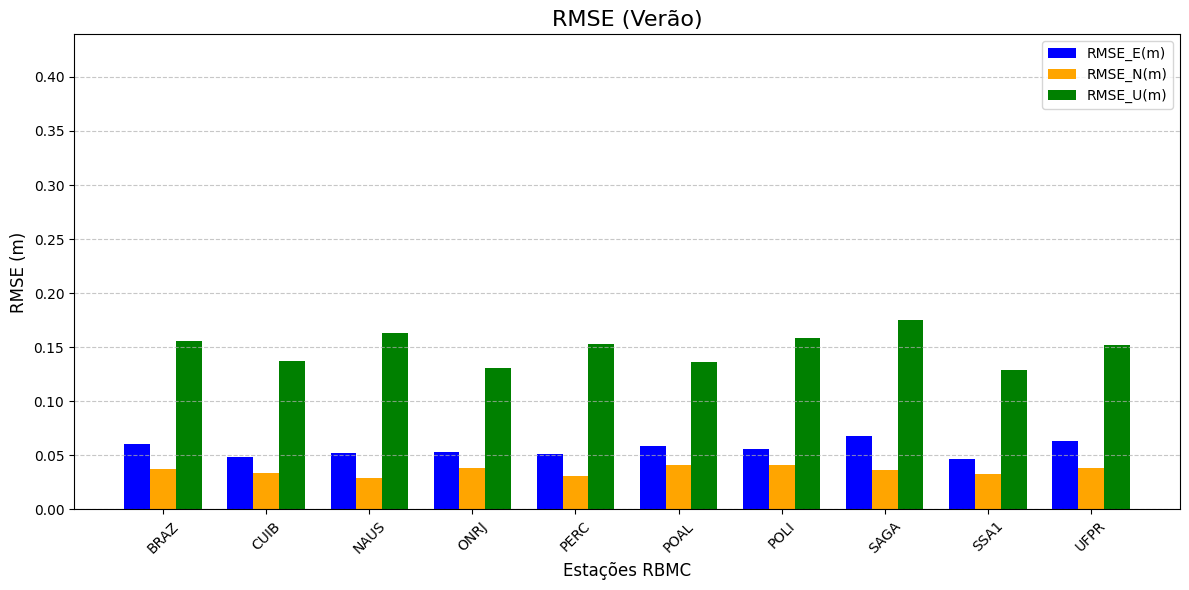

Histograma salvo em: charts\orig\rmse_julho_enu.png


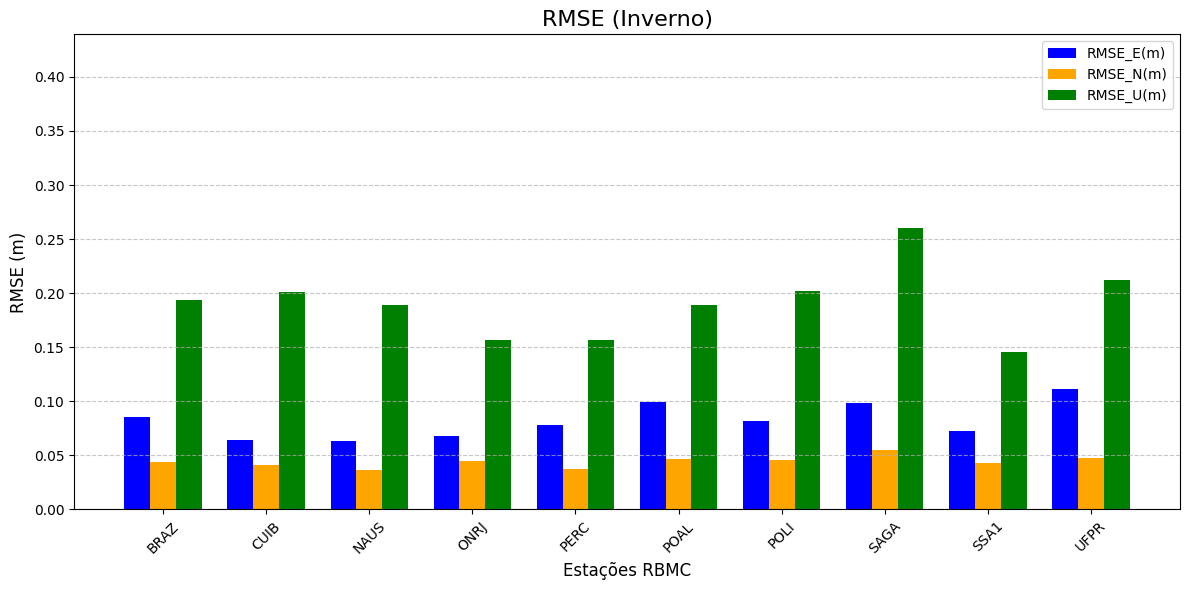

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Configurações para os histogramas
def plot_histograms(data, period, title, save_path, ymax):
    # Estações RBMC
    stations = np.sort(data['Estacao'].unique())  # Ordena as estações em ordem alfabética

    # Define o índice das estações
    x = np.arange(len(stations))

    # Largura das colunas
    width = 0.25

    # Valores RMSE para cada coordenada, ordenados pelas estações
    rmse_x = [data[data['Estacao'] == station]['RMSE_E'].mean() for station in stations]
    rmse_y = [data[data['Estacao'] == station]['RMSE_N'].mean() for station in stations]
    rmse_z = [data[data['Estacao'] == station]['RMSE_U'].mean() for station in stations]

    # Criação do gráfico
    fig, ax = plt.subplots(figsize=(12, 6))

    # Barras para cada RMSE
    ax.bar(x - width, rmse_x, width, label='RMSE_E(m)', color='blue')
    ax.bar(x, rmse_y, width, label='RMSE_N(m)', color='orange')
    ax.bar(x + width, rmse_z, width, label='RMSE_U(m)', color='green')

    # Configuração dos rótulos e título
    ax.set_xlabel('Estações RBMC', fontsize=12)
    ax.set_ylabel('RMSE (m)', fontsize=12)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(stations, rotation=45, fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Define o mesmo limite no eixo Y para todos os gráficos
    ax.set_ylim(0, ymax)

    # Ajusta layout
    plt.tight_layout()

    # Salva a figura
    plt.savefig(save_path)
    print(f"Histograma salvo em: {save_path}")
    plt.show()

# Filtra os dados para os períodos VERÃO (janeiro) e INVERNO (julho)
data_verao = df_results[df_results['Periodo'] == 'VERAO']
data_inverno = df_results[df_results['Periodo'] == 'INVERNO']

# Calcula o valor máximo global de RMSE
rmse_max = max(
    data_verao[['RMSE_E', 'RMSE_N', 'RMSE_U']].max().max(),
    data_inverno[['RMSE_E', 'RMSE_N', 'RMSE_U']].max().max()
)

# Gera o histograma para janeiro (VERÃO)
plot_histograms(
    data=data_verao,
    period='VERAO',
    title='RMSE (Verão)',
    # save_path=f'/content/drive/My Drive/VMF3/dados/{scenario}/rmse_histogram_janeiro.png',
    save_path = os.path.join(sc_charts_outpath,'rmse_janeiro_enu.png'),
    ymax=rmse_max
)

# Gera o histograma para julho (INVERNO)
plot_histograms(
    data=data_inverno,
    period='INVERNO',
    title='RMSE (Inverno)',
    # save_path=f'/content/drive/My Drive/VMF3/dados/{scenario}/rmse_histogram_julho.png',
    save_path = os.path.join(sc_charts_outpath,'rmse_julho_enu.png'),
    ymax=rmse_max
)

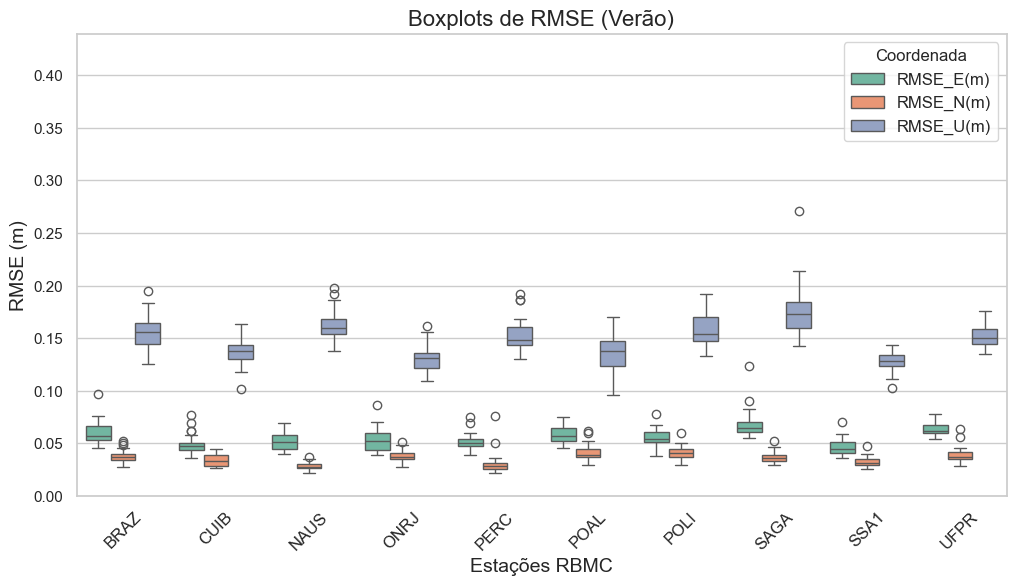

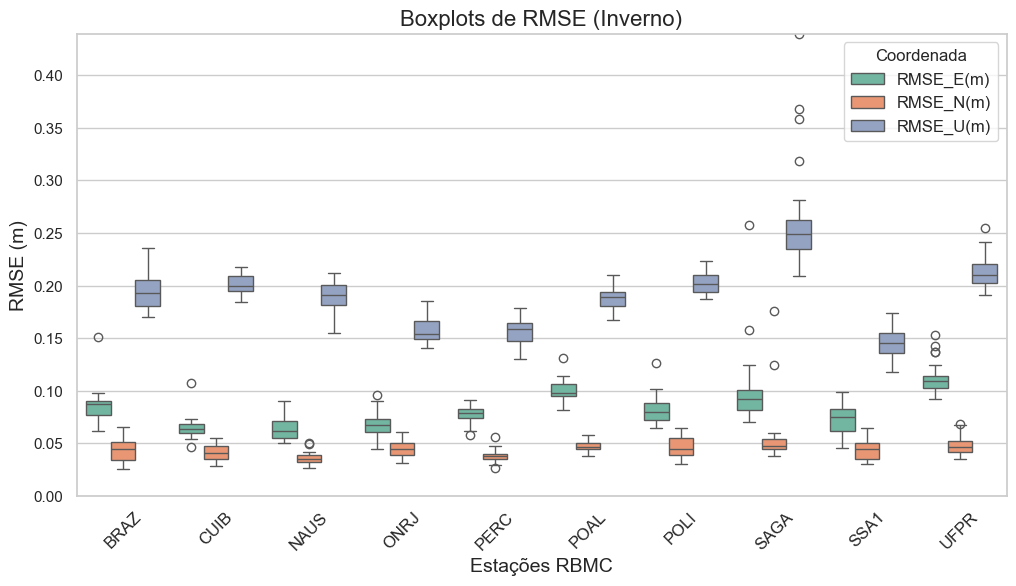

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações gerais de estilo
sns.set(style="whitegrid")

# Filtra os dados para os períodos de interesse
df_verao = df_results[df_results['Periodo'] == 'VERAO']
df_inverno = df_results[df_results['Periodo'] == 'INVERNO']

# Calcula o valor máximo global de RMSE para padronizar o eixo Y
rmse_max_global = df_results[['RMSE_E', 'RMSE_N', 'RMSE_U']].max().max()

# Função para criar boxplots para um período específico
def create_boxplot(data, periodo, output_file=None, ymax=None):
    # Ordena as estações em ordem alfabética
    data = data.sort_values(by='Estacao')

    # Transforma os dados no formato longo para facilitar o uso no Seaborn
    data_long = data.melt(
        id_vars=['Estacao'],
        value_vars=['RMSE_E', 'RMSE_N', 'RMSE_U'],
        var_name='Coordenada',
        value_name='RMSE'
    )

    # Substitui os nomes das coordenadas para incluir o sufixo (m)
    data_long['Coordenada'] = data_long['Coordenada'].replace({
        'RMSE_E': 'RMSE_E(m)',
        'RMSE_N': 'RMSE_N(m)',
        'RMSE_U': 'RMSE_U(m)'
    })

    # Cria o boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Estacao', y='RMSE', hue='Coordenada', data=data_long, palette='Set2')

    # Configurações do gráfico
    plt.title(f'Boxplots de RMSE ({periodo})', fontsize=16)
    plt.xlabel('Estações RBMC', fontsize=14)
    plt.ylabel('RMSE (m)', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='Coordenada', fontsize=12)

    # Ajusta o limite do eixo Y
    if ymax is not None:
        plt.ylim(0, ymax)

    # Salva o gráfico, se necessário
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')

    # Exibe o gráfico
    plt.show()


# Gera os boxplots para janeiro (verão)
boxplot_verao_path = os.path.join(sc_charts_outpath,'boxplot_verao_enu.png')
create_boxplot(df_verao, 'Verão', boxplot_verao_path, ymax=rmse_max_global)

# Gera os boxplots para julho (inverno)
boxplot_inverno_path = os.path.join(sc_charts_outpath,'boxplot_inverno_enu.png')
create_boxplot(df_inverno, 'Inverno', boxplot_inverno_path, ymax=rmse_max_global)


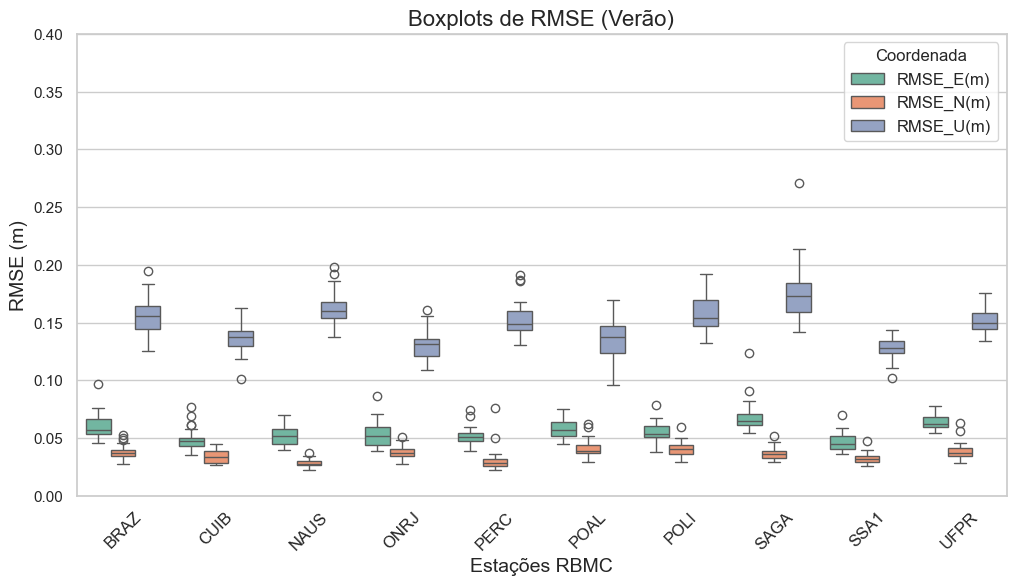

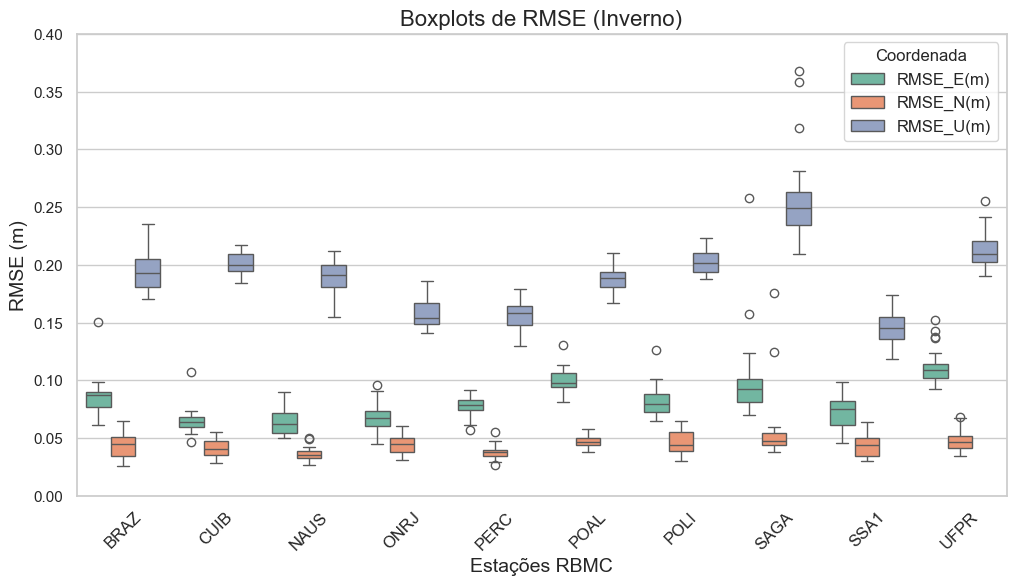

In [12]:
# Gera os boxplots para janeiro (verão) com limite máximo no eixo Y de 0.4
create_boxplot(df_verao, 'Verão', boxplot_verao_path.replace('.png','_v2.png'), ymax=0.4)

# Gera os boxplots para julho (inverno) com limite máximo no eixo Y de 0.4
create_boxplot(df_inverno, 'Inverno', boxplot_inverno_path.replace('.png','_v2.png'), ymax=0.4)



Histograma salvo em: charts\orig\rmse_janeiro_enu_sem_outliers.png


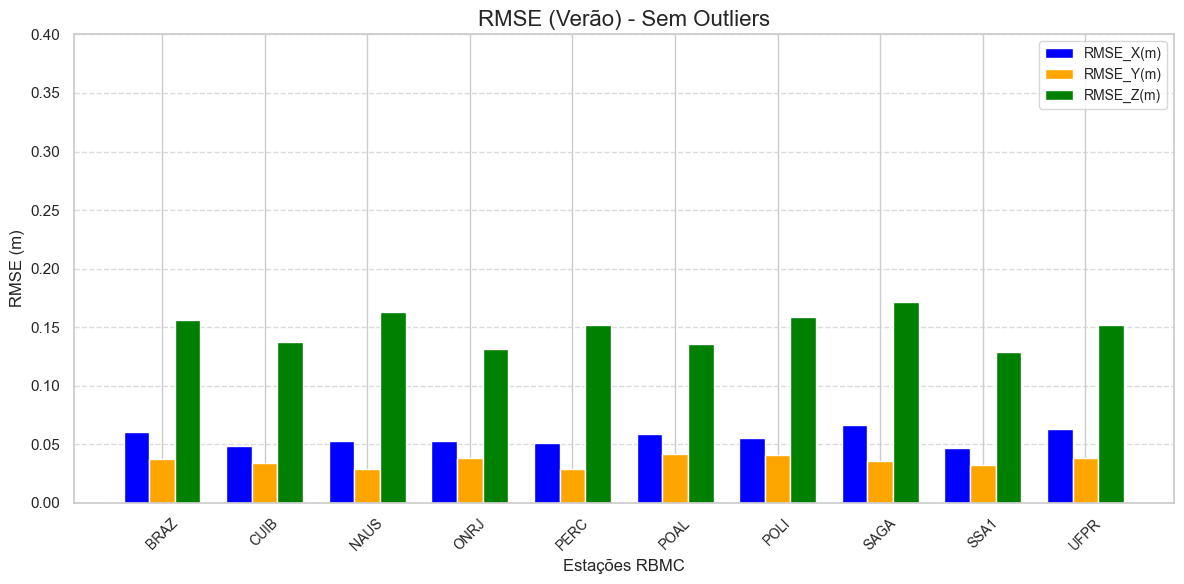

Histograma salvo em: charts\orig\rmse_julho_enu_sem_outliers.png


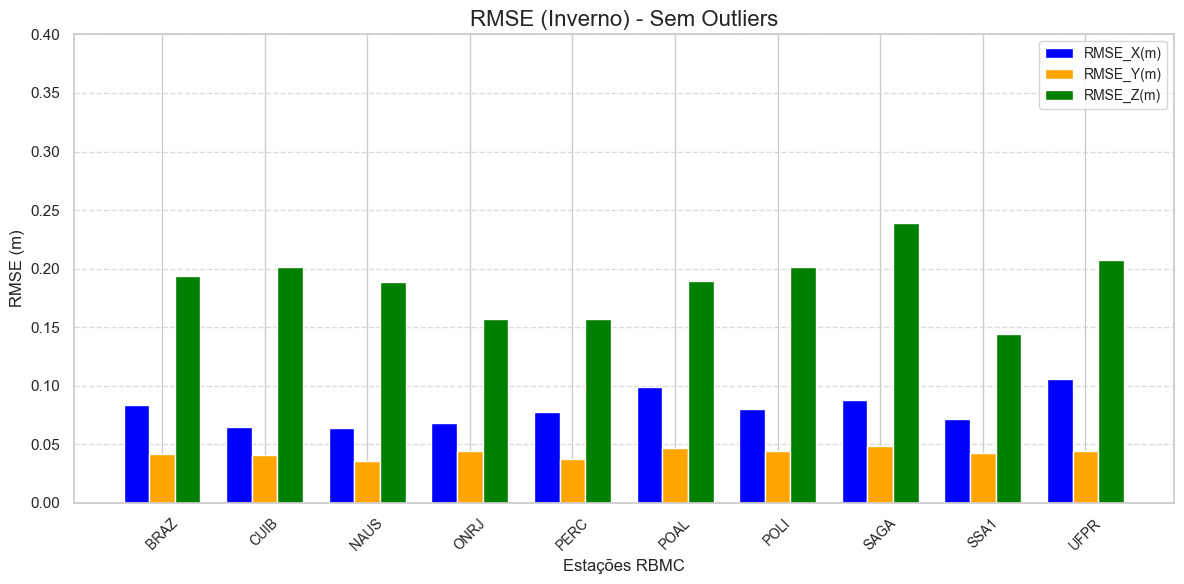

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Função para remover outliers
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Configurações para os histogramas
def plot_histograms(data, stations, rmse_x, rmse_y, rmse_z, title, save_path, y_max):
    # Define o índice das estações
    x = np.arange(len(stations))

    # Largura das colunas
    width = 0.25

    # Criação do gráfico
    fig, ax = plt.subplots(figsize=(12, 6))

    # Barras para cada RMSE
    ax.bar(x - width, rmse_x, width, label='RMSE_X(m)', color='blue')
    ax.bar(x, rmse_y, width, label='RMSE_Y(m)', color='orange')
    ax.bar(x + width, rmse_z, width, label='RMSE_Z(m)', color='green')

    # Configuração dos rótulos e título
    ax.set_xlabel('Estações RBMC', fontsize=12)
    ax.set_ylabel('RMSE (m)', fontsize=12)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(stations, rotation=45, fontsize=10)
    ax.set_ylim(0, y_max)  # Define a escala fixa para o eixo Y
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajusta layout
    plt.tight_layout()

    # Salva a figura
    plt.savefig(save_path)
    print(f"Histograma salvo em: {save_path}")
    plt.show()

# Remove outliers para todas as colunas
data_clean = remove_outliers(df_results, 'RMSE_E')
data_clean = remove_outliers(data_clean, 'RMSE_N')
data_clean = remove_outliers(data_clean, 'RMSE_U')

# Filtra os dados para os períodos VERÃO (janeiro) e INVERNO (julho)
data_verao = data_clean[data_clean['Periodo'] == 'VERAO']
data_inverno = data_clean[data_clean['Periodo'] == 'INVERNO']

# Estações RBMC e valores RMSE para ambos os períodos
stations = data_clean['Estacao'].unique()
stations.sort()

rmse_verao_x = [data_verao[data_verao['Estacao'] == station]['RMSE_E'].mean() for station in stations]
rmse_verao_y = [data_verao[data_verao['Estacao'] == station]['RMSE_N'].mean() for station in stations]
rmse_verao_z = [data_verao[data_verao['Estacao'] == station]['RMSE_U'].mean() for station in stations]

rmse_inverno_x = [data_inverno[data_inverno['Estacao'] == station]['RMSE_E'].mean() for station in stations]
rmse_inverno_y = [data_inverno[data_inverno['Estacao'] == station]['RMSE_N'].mean() for station in stations]
rmse_inverno_z = [data_inverno[data_inverno['Estacao'] == station]['RMSE_U'].mean() for station in stations]

# Determina o limite máximo do eixo Y
y_max = max(
    max(rmse_verao_x + rmse_verao_y + rmse_verao_z),
    max(rmse_inverno_x + rmse_inverno_y + rmse_inverno_z),
) * 1.1  # Adiciona 10% de margem

# Gera o histograma para janeiro (VERÃO)
plot_histograms(
    data=data_verao,
    stations=stations,
    rmse_x=rmse_verao_x,
    rmse_y=rmse_verao_y,
    rmse_z=rmse_verao_z,
    title='RMSE (Verão) - Sem Outliers',
    # save_path=f'/content/drive/My Drive/VMF3/dados/{scenario}/rmse_histogram_janeiro_Sem outliers.png',
    save_path = os.path.join(sc_charts_outpath,'rmse_janeiro_enu_sem_outliers.png'),
    y_max=0.4 #y_max
)

# Gera o histograma para julho (INVERNO)
plot_histograms(
    data=data_inverno,
    stations=stations,
    rmse_x=rmse_inverno_x,
    rmse_y=rmse_inverno_y,
    rmse_z=rmse_inverno_z,
    title='RMSE (Inverno) - Sem Outliers',
    # save_path=f'/content/drive/My Drive/VMF3/dados/{scenario}/rmse_histogram_julho_Sem outliers.png',
    save_path=os.path.join(sc_charts_outpath,'rmse_julho_enu_sem_outliers.png'),
    y_max=0.4 #y_max
)
